In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
import os
import re
import datetime as dt
import random
import pickle
import shutil
import subprocess

# opencv
import cv2

# tensorflow/keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Lambda, Concatenate,Flatten, concatenate, LSTM, MaxPooling2D, Permute, Reshape, TimeDistributed
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.data_utils import Sequence
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
# import resnet
from tensorflow.keras.applications import ResNet50

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

# custom
from utilities import extract_position_time, normalize_datetime, \
normalize_y, get_lat_long_bounds, normalize_times, un_normalize, \
confidence_ellipse
from image_generator import get_waypoints, show_training_grid, plot_lat_long

# Project Overview
---
### Notebooks

1. [Exploratory Data Analysis](../code/eda_notebook.ipynb)
2. [Data Cleaning and preparation](../code/data_cleaning_notebook.ipynb)
3. [Modeling Explanation and Analysis](../code/modeling_notebook.ipynb) [This Notebook]

### Scripts
- [image generation](../code/image_generator.py)
- [utility functions](../code/utilities.py)

---

# Notebook Summary

## III. Modeling

---

Read in files

In [2]:
files_train = os.listdir('../images/train')
files_train = [f for f in files_train if f.endswith('.png')]

files = files_train 

# create array of position
position = np.array([extract_position_time(f)[0] for f in files])

# create array of time
times = np.array([extract_position_time(f)[1] for f in files])

# Project Structure


# Loss Functions

There is a non-linear relationship between Latitude and Longitude. Rather than use Root Mean Square Error or another more commonly used ML metric, we first tried to use Mercator sailing as a loss function:
### Mercator Loss

A Mercator sailing is similar to plane sailing and is a trigonometric solution to course and distance on a mercator projection, however it accounts for the curvature of the earth by using the meridional parts of a Latitude:
$$
\begin{align*}
mp = 7915.7 \log(\tan(45 + \frac{\phi_n}{2}))- 23.2689 \times \sin(\phi_n) \\
\end{align*}
$$

$$
\textrm{Where} \ \phi_n = Latitude
$$

### Differentiation 

However, during model training it quickly became clear that Mercator sailing was not an appropriate loss function, as Mercator sailing is not a differentiable function at the poles -- the tangent function becomes undefined at these points. 

$tan(x) = \frac{sin(x)}{cos(x)} = \frac{1}{0}$ (at latitude = +90 degrees)

or

$tan(x) = \frac{sin(x)}{cos(x)} = \frac{-1}{0}$ (at latitude = -90 degrees)

A differentiable function is one whose derivative exists at every point in its domain, which is a requirement for algorithms used in machine learning to calculate the gradient of the loss function and update the model's parameters accordingly.

Instead, we turned to the solution used in this very similar and interesting project by Capt. Greg Tozzi: [Deep Learning CelNav](https://github.com/gregtozzi/deep_learning_celnav). Additional research showed succesful implementation of the Haversine formula in distance-based deep learning projects. [[Example]](https://towardsdatascience.com/lessons-from-a-deep-learning-master-1e38404dd2d5). 

### Haversine Loss

Given two points with latitudes $\phi_1$ and $\phi_2$, and longitudes $\lambda_1$ and $\lambda_2$, the initial course $\theta$ and distance $d$ between the points are given by:

$\theta = \arctan2(\sin(\Delta\lambda)\cos\phi_2, \cos\phi_1\sin\phi_2 - \sin\phi_1\cos\phi_2\cos(\Delta\lambda))$

$d = 2R\arcsin\sqrt{\sin^2(\frac{\phi_2-\phi_1}{2}) + \cos\phi_1\cos\phi_2\sin^2(\frac{\Delta\lambda}{2})}$

where $\Delta\lambda = \lambda_2 - \lambda_1$, $R$ is the radius of the sphere, and $\arctan2(y,x)$ returns the arctangent of $y/x$ taking into account the signs of $y$ and $x$ to determine the correct quadrant.

### Performance 

During modeling, the Haversine formula performed well using the  Adaptive Moment Estimation (Adam) optimization algorithm. With training and validation loss converging to 1.59 Nautical Miles after 68 epochs of training. 

![](../md_images/training_loss.png)

Great Circle

In [3]:
def haversine_loss(y_true, y_pred, R=3440):
    # taken with very minor modifications from this very similar project:
    # https://github.com/gregtozzi/deep_learning_celnav

    # un-normalize the lat and long
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min 
    
    # Compute phis and lambdas 
    phi1 = lat1 * np.pi / 180
    phi2 = lat2 * np.pi / 180
    delta_phi    = (lat2 - lat1) * np.pi / 180
    delta_lambda = (long2 - long1) * np.pi / 180
    
    # Intermediate computations
    a = tf.square(tf.sin(delta_phi / 2)) + tf.cos(phi1) * tf.cos(phi2) * tf.square(tf.sin(delta_lambda / 2))
    c = 2 * tf.atan2(tf.sqrt(a), tf.sqrt(1 - a))
    
    # Compute distances
    d = R * c

    return tf.reduce_mean(d)

def haversine_loss_2_nautical_miles(y_true, y_pred):
    R = 3440  # radius of Earth in nautical miles
    lat1, lon1 = np.deg2rad(y_true[:, 0]), np.deg2rad(y_true[:, 1])
    lat2, lon2 = np.deg2rad(y_pred[:, 0]), np.deg2rad(y_pred[:, 1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

Mercator

In [4]:
def mercator_loss(y_true, y_pred):
    # Convert normalized lat and long into actuals
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)
    lat1  = y_true[:,0] * lat_range + lat_min
    lat2  = y_pred[:,0] * lat_range + lat_min
    long1 = y_true[:,1] * long_range + long_min
    long2 = y_pred[:,1] * long_range + long_min

    # compute meridional parts
    mpartsinitial = 7915.7045 * np.log10(
                np.tan(np.pi / 4 + (np.deg2rad(lat1) / 2))) - 23.2689 * np.sin(
                np.deg2rad(lat1))
    mpartssecond = 7915.7045 * np.log10(np.tan(np.pi / 4 + (np.deg2rad(lat2) / 2))) - 23.2689 * np.sin(
                np.deg2rad(lat2))
                
    little1 = (mpartssecond - mpartsinitial) 
    
    # compute dlat
    dlat = np.deg2rad(lat2 - lat1)

    # compute dlong
    dlong = np.deg2rad(long2 - long1)

    # compute course
    course = np.arctan2(dlong,np.deg2rad(little1/60))

    # compute distance
    d = np.rad2deg(dlat/np.cos(course)) * 60

    return tf.reduce_mean(d)

# Generator Functions

In [5]:
class CustomGenerator(Sequence):
    def __init__(self, directory, batch_size=32, segment = 'Train'):
        
        self.directory = directory
        self.batch_size = batch_size
        self.segment = segment

    def __len__(self):
      if self.segment !='Train':
        return int(np.floor(len(files_val) / self.batch_size))
      else:
        return int(np.floor(len(files_train) / self.batch_size))

    def __getitem__(self, idx):

        # get batch of images
        batch = os.listdir(self.directory)[idx * self.batch_size:(idx + 1) * self.batch_size]
        # create empty array to hold images
        # batch.sort()
        x = np.empty((self.batch_size, 224, 224, 1))
        y = np.zeros((self.batch_size, 2))
        times_gen = []
        # loop through batch
      
        for i, img in enumerate(batch):
            # populate time and position labels 
            y[i] = extract_position_time(img)[0]
            time = extract_position_time(img)[1]
            times_gen.append(normalize_datetime(time, times.min(), times.max()))
             # read image
            img = cv2.imread(os.path.join(self.directory, img),0)
            img = cv2.resize(img, (224, 224))
            # add image to x
            x[i] = img.reshape(224, 224, 1)

        # get output
        output = normalize_y(y, position)
           
        # get time input
        time_input = np.array(times_gen) 
        
        return [x/255, time_input], output

custom_gen_train = CustomGenerator(directory = '../images/train', segment = 'Train')
custom_gen_val = CustomGenerator(directory = '../images/valid', segment = 'Validate')

Due to the very large amount of images we needed to process it became necessary to inplement a custom generator function. Even using Google Collab's generous 35 GB of RAM, an array of the > 78,000 processed images quickly overwhelmed all available ram and the kernel would crash. 

The above custom generator is an adaptation of the one found [here](https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3).

The class inherits from TensorFlow's `Sequence` class and prepares the image, time, and position variables for the model. The `__len__` method returns the number of batches to be generated and the `__getitem__` method returns a single batch of data (32 images, times and positions). 

The majority of the work is done in a for loop. The loop iterates through each image in the batch, and for each image:
1. The position and time labels are extracted using the images file name using `extract_position_time` function. The file name syntax is in this format: `L37.9493LON-138.9558T2020-03-13-08-00-00.png`

2. The image is read and resized to (224, 224) using OpenCV's `cv2.imread` and `cv2.resize` functions.

3. The image is then added to the x array as a 3-D array with shape (224, 224, 1).

4. The time label for each image is normalized using the `normalize_datetime` function and appended to an array. 

After the for-loop, the output variable, the latitude and longitude label for the image is normalized using the `normalize_y` position.


Finally, the x array is normalized by dividing by 255 and time_input are returned as inputs, and the output is returned as the target.

# Model Topology


In [6]:
# from tensorflow.keras.layers import Layer
class MCdropout(Dropout):
    # code from this source: https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571
    def call(self, inputs):
        return super().call(inputs, training=True)

input_image = Input(shape=(224,224,1))
input_time = Input(shape=times[0].shape)

# process the input image using a CNN
x = Conv2D(filters=16, kernel_size=3, padding='same', activation='relu')(input_image)
x = MaxPooling2D()(x)
x = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
x = Flatten()(x)

# flatten the input time
t = Flatten()(input_time)

# Pass the time input through 3 dense layers
t = Dense(128, activation='relu')(t)
t = Dense(64, activation='relu')(t)
t = Dense(32, activation='relu')(t)

# concatenate the output of the CNN and LSTM layers
z = concatenate([x, t])
z = Dense(256, activation='relu')(z)
z = MCdropout(0.2)(z) # MC Dropout layer
z = Dense(256, activation='relu')(z)
z = MCdropout(0.2)(z) # MC Dropout layer

# define the output layer
outputs = Dense(2, activation='sigmoid')(z)

mcmodel = Model(inputs=[input_image, input_time], outputs=outputs)

In [7]:
mcmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 16  0           ['conv2d[0][0]']                 
                                )                                                             

# Models

Our initial goal with this project was to construct a hybrid CNN-LSTM model, with the intuition that using the convolutional layers for the sequence of images and the LSTM layers for the sequence of times was an approach that might yield strong temporal-interpolative results and reduce the number of trainign images. This approach proved to be difficult to manage and our results were quite poor.

Our second (and primary) model takes two inputs: an input image (tensor) and an input time (tensor). The input image is processed by a series of Convolutional layers, which consist of three Conv2D layers with 16, 32, and 64 filters respectively, each with a kernel size of 3 and ReLU activation. Between each Conv2D layer is a MaxPooling2D layer and the output from the last Conv2D layer is flattened using a Flatten layer.

The input time is processed by a series of Dense layers. The time tensor is first flattened using a Flatten layer and then passed through three Dense layers with 128, 64, and 32 neurons respectively, each with ReLU activation.

The output from the CNN and Dense layers are concatenated and passed through two Dense layers with 256 neurons each, with ReLU activation. Both Dense layers are followed by Monte Carlo Dropout layers with a dropout rate of 0.2. The final output is produced by a Dense layer with 2 neurons and sigmoid activation, which outputs a vector of two values between 0 and 1 representing the predicted latitude and longitude, which are unnormalized to recover the predicted latitude and longitude.


### Convolutional Neural Networks, Broadly Explained:

A convolutional neural network is a deep learning network that has proved to be particularly good for image classification and object detection. The network functions by passing the input image which is now transformed into a tensor(--a multi dimensional matrix) through a number of layers which are outlined below:

1. Convolutional Layers: These layers slide a small matrix (called a kernel) over the image matrix and find the dot product between  the the kernel and the portion over which the kernel is hovering. We add a bias to the dot product and put the output into a feature map. The kernel will move to the right over the input image matrix a given amount (called stride value) until it completes the full width of the image matrix. It then moves back to the left side of the image matrix but down a row and continues the same process until it has traversed the entire image and the feature map is full. The feature map is then run through a ReLU activation function ($f(x) = max(0,x)$) which sets all of the negative values to 0 and the positive values remain the same. The feature map is then sent to a Max Pooling Layer:

2. Max Pooling Layers: A max poolying layer is another small matrix filter that traverses our feature map and selects the maximum value from the portion of the feature map over which it is hovering. The overall effect is we reduce the feature map to the maximum values from each region from the input image and the number of important features is reduced. The Max Pooling Layer is then flattened:

3. Flatten Layers: Flatten layers do not extract any useful features from the input image, they simply take the feature map that has been created and refined by the convolutional and pooling layers and convert it into a vector.

4. Dense Layers: The output from the flatten layer is then passed through one or more dense layers, also known as fully connected layers. In these layers, each neuron is connected to every neuron in the previous layer. A neuron receives inputs from the previous layer, performs computations on those inputs, and produces an output that is passed to the next layer.

    A neuron is just an information collection and processing function. It receives inputs from the previous layer, performs computations on those inputs, and produces an output that is passed to the next layer. In a dense layer, each neuron receives inputs from all the neurons in the previous layer and performs the following computation:

    $$output = ReLU(inputs * weights + bias)$$

    Where inputs are the inputs from the previous layer, weights are the weights associated with each input, bias is a constant value that is added to the computation, and ReLU is the activation function that transforms the output into a vector of values, each representing the output of a single neuron in the layer. These values are then sent to drop out layers:

5. Dropout Layers:  A dropout layer takes the output from the dense layer and randomly turns off a specified percentage of neurons during each forward pass, which reduces the interactions between neurons and prevents the model from overfitting. The output tensor from a dropout layer is then fed into a final Dense output layer where another activation function is applied. In our model, we make use of MC Dropout layers:

### MC Dropout

Normal dropout layers only dropout at training time, and serve as regularization to curb overfitting. For prediction time, the dropout is not applied and all nodes/connections are present. The model is thus deterministic: it will make the same prediction every time. 

For Monte Carlo dropout, the dropout is applied during training and during prediction time. Thus the prediction is no longer determinisitic but is now dependent on the nodes and links that were randomly chosen to be kept, and as a result, we will get a different prediction every time the model runs. 

The utility of this process is that we can now interpret the output of the model in a probabilistic way. A predicted position is no longer a single prediction, but is instead the mean of 100 predictions for the image, and from this distribution of predictions we are able to fix the position with a specified degree of statistical confidence and present the results visually with a confidence ellipse. 

### Sigmoid Function as Output

The sigmoid activation function is commonly used in binary classification problems, where the output is between 0 and 1, and the value represents the probability of a given instance belong to 1 of 2 classes. 

In this specific use case, the final dense layer has 2 neurons and sigmoid activation will output two values between 0 and 1, which are the normalized predictions for latitude and longitude. To recover latitude and longitude we simply un-normalize these values using the values we used to normalize the training data. 


### Sources

---

(1) [Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

(2) [Monte Carlo Dropout](https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571)

(3) [Towards Automated Celestial Navigation](https://github.com/gregtozzi/deep_learning_celnav) [A very similar project that heavily influenced this project]


Load Model

In [8]:
# load monte carlo model using custom_object_scope
with tf.keras.utils.custom_object_scope({'haversine_loss': haversine_loss, 'MCdropout': MCdropout}):
    mcmodel = tf.keras.models.load_model('../models/mc_model_3.h5')

# Predictions

In [9]:
def predict_positions(path, n_preds = 100):
    # load voyage images
    files_voy = os.listdir(path)
    files_voy = [f for f in files_voy if f.endswith('.png')]
    files_voy.sort()
    X_voy = np.zeros((len(files_voy), 224, 224))

    # read images using opencv and resize to 224x224
    for i, f in enumerate(files_voy):
        img = cv2.imread(path + f, 0)
        img = cv2.resize(img, (224, 224))
        img
        X_voy[i] = img
    X_voy = np.expand_dims(X_voy/255, 3)

    # create array of voyage positions
    position_voy = np.array([extract_position_time(f)[0] for f in files_voy])

    # create array of voyage times
    times_voy = np.array([extract_position_time(f)[1] for f in files_voy])

    # normalize voyage positions
    y_voy = normalize_y(position_voy, master_pos = position  )

    # normalize voyage times
    t_voy = normalize_times(times_voy, master_times = times)

    preds_mc = []

    # get lat and long bounds to unnormalize
    lat_min, lat_range, long_min, long_range = get_lat_long_bounds(position)

    print(f'Predictng Each Position {n_preds} Times')

    # predict voyage positions using monte carlo dropout
    for x in range(len(X_voy)):
        intermediate_preds = []
        for i in range(n_preds):
            image = X_voy[x]
            time = t_voy[x]
            image = np.expand_dims(image, 0)
            time = np.expand_dims(time, 0)
            y_pred = mcmodel.predict([image, time], verbose=0)
            pred_pos = un_normalize(y_pred, lat_range, lat_min, long_range, long_min)
            intermediate_preds.append(pred_pos)
        preds_mc.append(np.array(intermediate_preds))

    act_pos = un_normalize(y_voy, lat_range, lat_min, long_range, long_min)
    mean_latitudes = [preds_mc[i][:,0][:,0].mean() for i in range(len(preds_mc))]
    mean_longitudes = [preds_mc[i][:,0][:,1].mean() for i in range(len(preds_mc))]
    monte_carlo_df = pd.DataFrame()
    monte_carlo_df['time'] = times_voy
    monte_carlo_df['pred_lat'] = mean_latitudes
    monte_carlo_df['pred_long'] = mean_longitudes
    monte_carlo_df['actual_lat'] = act_pos[:,0]
    monte_carlo_df['actual_long'] = act_pos[:,1]
    monte_carlo_df['Error'] = haversine_loss_2_nautical_miles (act_pos, np.array([mean_latitudes, mean_longitudes]).T)
 
    return monte_carlo_df, preds_mc, act_pos


# Position Fixing With Confidence Ellipses

The production model predicts a position by iterating over an image of the sky 100 times. The Monte Carlo Dropout layers make multiple forward passes with different dropout masks, creating 100 different position predictions for each image. The resulting arrays of predicted latitudes and longitudes are used to calculate a covariance matrix for the position. From the covariance matrix, a confidence ellipse is rendered via Eigendecomposition and scaling. The steps are as follows:

1. Decompose the covariance matrix into eigenvalues and eigenvectors: The covariance matrix is a symmetric matrix, so it can be decomposed into a set of eigenvalues and eigenvectors, which describe the magnitude and direction of the variances in the data.

2. Determine the confidence level: A confidence level of .95 was chosen for the model. 

3. Scale the eigenvectors: The eigenvectors are scaled by the square root of the eigenvalues and multiplied by a factor corresponding to the desired confidence level. This gives the semi-axes of the ellipse.

4. Plot the ellipse: The scaled eigenvectors are used to define the axes of the ellipse, and the center of the ellipse is located at the mean of the predicted latitudes and longitudes. The ellipse is then plotted, representing the region in which the data is expected to fall with the desired level of confidence.

5. The resulting confidence ellipse provides a visual representation of the uncertainty of the predicted position, with the most probable position located within the ellipse. 


### Sources

---

(1) [Confidence Ellipse](https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/)

(2) [EigenDecomposition](https://rukshanpramoditha.medium.com/eigendecomposition-of-a-covariance-matrix-with-numpy-c953334c965d)

(3) [Code](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)

# Results

1 Hour Fix Frequency 

Predictng Each Position 100 Times
Mean Position Error: 0.78 NM
Standard Deviation of Position Error: 0.65 NM


,time,pred_lat,pred_long,actual_lat,actual_long,Error
0,2020-03-13 08:00:00,37.946201,-138.959305,37.9493,-138.9558,0.249021
1,2020-03-13 07:00:00,38.210838,-139.209106,38.2120,-139.2154,0.305083
2,2020-03-13 06:00:00,38.470959,-139.482437,38.4747,-139.4760,0.376764
3,2020-03-13 05:00:00,38.715603,-139.727890,38.7373,-139.7375,1.378374
4,2020-03-13 04:00:00,38.975033,-139.988602,39.0000,-140.0000,1.590489


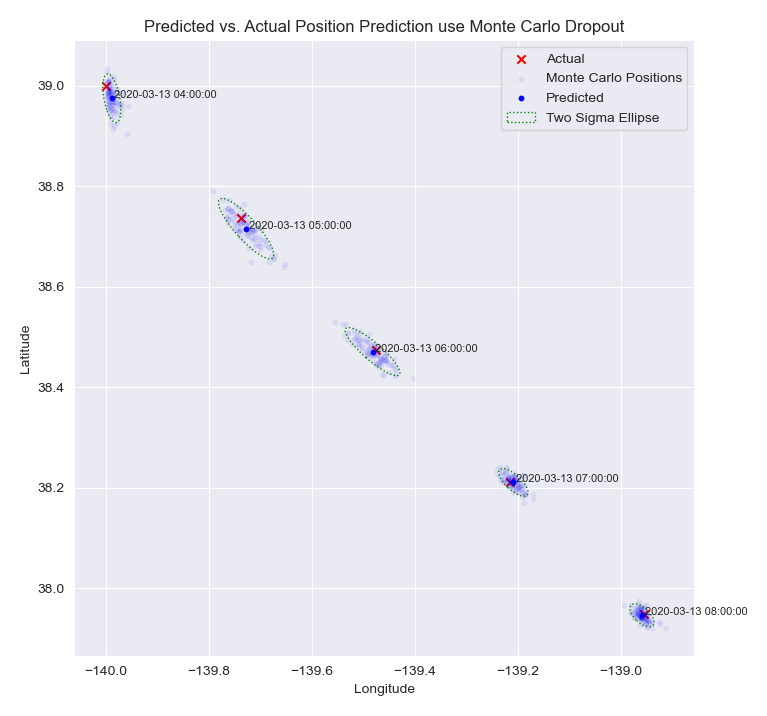

In [10]:
path = '../images_val/voyage_sims/voyages/60/' 
monte_carlo_df, preds_mc, act_pos = predict_positions(path)

print('Mean Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].mean()))
print('Standard Deviation of Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].std()))

display(monte_carlo_df)

plot_lat_long(preds_mc, act_pos, monte_carlo_df,show_track = False)

Above we see the plotted results and predictions from a 4-hour watch on our fictious voyage, fixing the position each hour. 

The model predicts each individual position 100 times, and the mean of the 100 predictions (plotted as a blue dot) is taken as the predicted position and a confidence ellipse surrounds all of the predictions. A red X marks the actual position. 

Since the model was trained every 6 minutes (and the temporal resolution for position fixing is on the hour), and the vessel did not deviate from the training grid, we find that our predictions are quite good. Our Mean positional error is .80 NM with a standard deviation of .56 NM. 

30 Minutes

Predictng Each Position 100 Times
Mean Position Error: 0.67 NM
Standard Deviation of Position Error: 0.53 NM


,time,pred_lat,pred_long,actual_lat,actual_long,Error
0,2020-03-13 08:00:00,37.949146,-138.959763,37.9493,-138.9558,0.187785
1,2020-03-13 07:30:00,38.070633,-139.078705,38.0807,-139.0855,0.684425
2,2020-03-13 07:00:00,38.208290,-139.208664,38.2120,-139.2154,0.387943
3,2020-03-13 06:30:00,38.342037,-139.348969,38.3433,-139.3456,0.176052
4,2020-03-13 06:00:00,38.465992,-139.478226,38.4747,-139.4760,0.533146
5,2020-03-13 05:30:00,38.598503,-139.611694,38.6060,-139.6066,0.509586
6,2020-03-13 05:00:00,38.718468,-139.732971,38.7373,-139.7375,1.150457
7,2020-03-13 04:30:00,38.840466,-139.861038,38.8687,-139.8686,1.731746


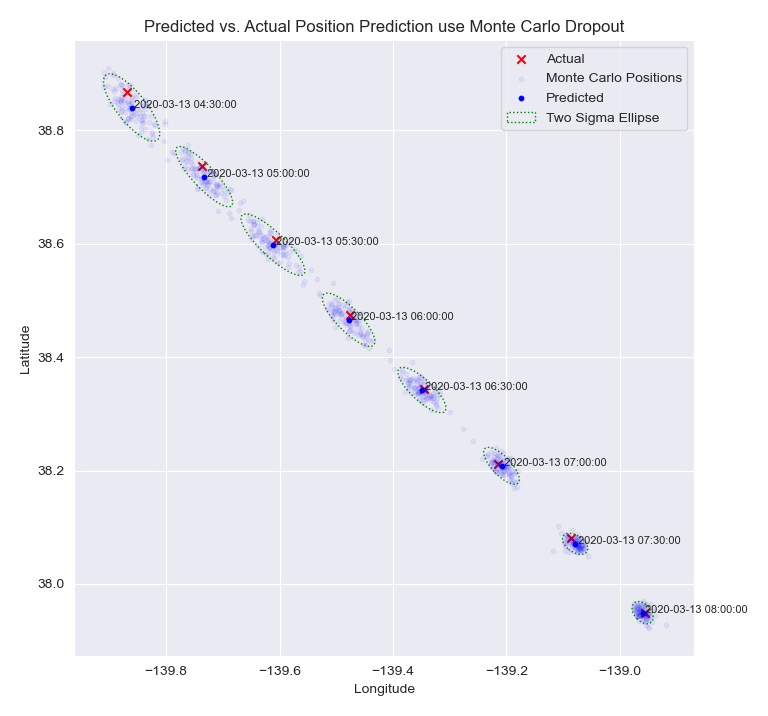

In [11]:
path = '../images_val/voyage_sims/voyages/30/' 
monte_carlo_df, preds_mc, act_pos = predict_positions(path)

print('Mean Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].mean()))
print('Standard Deviation of Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].std()))

display(monte_carlo_df)

plot_lat_long(preds_mc, act_pos, monte_carlo_df,show_track = False)

We achieve similar results at the 30 minute level, with a mean prediction error of .57 nautical miles from the actual position and a standard deviation of .37 nm.

6 Minutes

Predictng Each Position 100 Times
Mean Position Error: 0.89 NM
Standard Deviation of Position Error: 0.48 NM


,time,pred_lat,pred_long,actual_lat,actual_long,Error
0,2020-03-13 08:00:00,37.946747,-138.959793,37.9493,-138.9558,0.243307
1,2020-03-13 07:54:00,37.974518,-138.977783,37.9756,-138.9817,0.196619
2,2020-03-13 07:48:00,37.990246,-138.999710,38.0019,-139.0076,0.793157
3,2020-03-13 07:42:00,38.017574,-139.028610,38.0281,-139.0336,0.674608
4,2020-03-13 07:36:00,38.041615,-139.061493,38.0544,-139.0595,0.773478
5,2020-03-13 07:30:00,38.070866,-139.078171,38.0807,-139.0855,0.684538
6,2020-03-13 07:24:00,38.105305,-139.112701,38.1069,-139.1114,0.113877
7,2020-03-13 07:18:00,38.124290,-139.128464,38.1332,-139.1374,0.681344
8,2020-03-13 07:12:00,38.148071,-139.167908,38.1595,-139.1634,0.718359
9,2020-03-13 07:06:00,38.174217,-139.187668,38.1857,-139.1894,0.694209


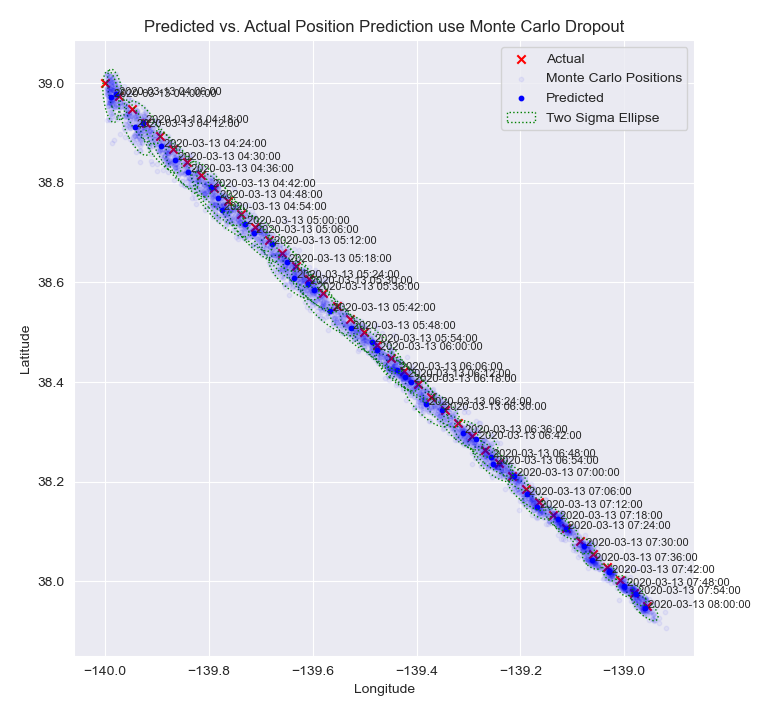

In [12]:
path = '../images_val/voyage_sims/voyages/6/'

monte_carlo_df, preds_mc, act_pos = predict_positions(path)

print('Mean Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].mean()))
print('Standard Deviation of Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].std()))

display(monte_carlo_df)

plot_lat_long(preds_mc, act_pos, monte_carlo_df,show_track = False)

Again, at the 6 minute resolution, we find encouraging results, with a mean position fixing error of .87 nm and a standard deviation of .42 nm.

---

The results suggest that the construction of the densely layered spatio-temporal training grid is valid. 

The spaces between the training positions were all roughly 1 NM and as we analyze the results above we see that the prediction error is roughly 1 nm at the 3 different fix frequencies.  

| Fix Frequency | Mean Positional Error (NM) | Standard Dev. Positional Error (NM) |
| ------------- | -------------------------- | ----------------------------------- |
| 1 Hour        | 0.78                       | 0.65                                 |
| 30 Minutes    | 0.67                        | 0.53                                 |
| 6 Minutes     | 0.88                        | 0.48                                 | 




# Where this System Breaks Down

## I. Times outside of base 6 training interval

Predictng Each Position 100 Times
Mean Position Error: 7.06 NM
Standard Deviation of Position Error: 6.04 NM


,time,pred_lat,pred_long,actual_lat,actual_long,Error
0,2020-03-13 08:00:00,37.945587,-138.956833,37.9493,-138.9558,0.228268
1,2020-03-13 07:40:00,38.086525,-139.171661,38.0369,-139.0422,6.806602
2,2020-03-13 07:20:00,37.966888,-138.781815,38.1244,-139.1288,18.936952
3,2020-03-13 07:00:00,38.208340,-139.211639,38.2120,-139.2154,0.282757
4,2020-03-13 06:40:00,38.271339,-139.468964,38.2995,-139.3022,8.038964
5,2020-03-13 06:20:00,38.314224,-139.107819,38.3871,-139.3890,13.943851
6,2020-03-13 06:00:00,38.464169,-139.475891,38.4747,-139.4760,0.632275
7,2020-03-13 05:40:00,38.600292,-139.795776,38.5622,-139.5630,11.161993
8,2020-03-13 05:20:00,38.735703,-139.454407,38.6498,-139.6502,10.525491
9,2020-03-13 05:00:00,38.721298,-139.735779,38.7373,-139.7375,0.964082


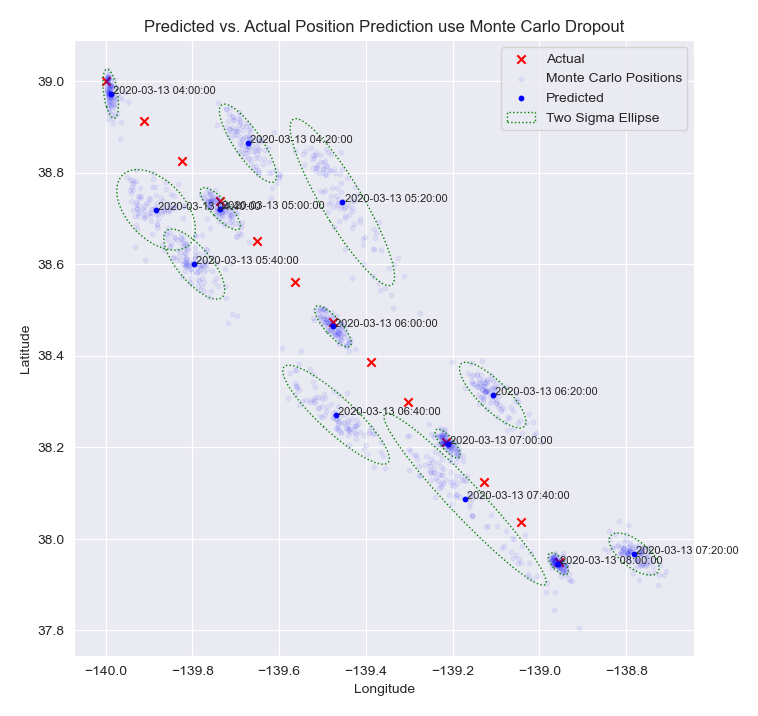

In [13]:
path = '../images_val/voyage_sims/voyages/20/' 
monte_carlo_df, preds_mc, act_pos = predict_positions(path)

print('Mean Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].mean()))
print('Standard Deviation of Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].std()))

display(monte_carlo_df)

plot_lat_long(preds_mc, act_pos, monte_carlo_df,show_track = False)

The above results show our model's struggles with temporal interpolation. 


**The Problem**

Since the model was trained using a 6 minute interval over a 4 hour period it has a sequential understanding of the sky for :06, :12, :18, :24, :30, :48, :54 minutes after the hour. What it is unable to do is interpolate the difference between what the sky looks like inbetween 4:18 and 4:24 for the time 4:20. The predicted positions suggest the model picks positions almost randomly when it is given images of the sky at different temporal resolutions than it was trained on. 

In practice, this isn't much of an issue. A ship is going to use GPS navigation at all times and rely on this potential system in the event that their primary navigational system as failed completely. In sight of land, terrestrial navigational methods such as RADAR ranges and bearings will be used. Offshore, in the middle of the ocean, it is rarely the case that a position needs to be fixed more frequently than 1 hour. The 6 minute position fixing and training interval chosen for the model selection was simply an effort to improve temporal interpolation. 

Temporal interpolation was mentioned as a blocking point and area for furhter study in the excellent and similar project [Towards Automated Celestial Navigation](https://github.com/gregtozzi/deep_learning_celnav). Our hope was that our differently constructed spatio-temporal training grid's dense layering and more complex model might solve this issue but it clearly has not found success. 

It then seems that there is one obvious solution to this problem and another more elegant but obscure solution:

**Solution I. Brute Force**

The most obvious solution is simply to create the training images at the desired fix frequency. If a fix is desired every minute, then with the exisiting model architecture an image of the sky for every minute for every position in the training grid will have to be constructed. This approach however, is intensive. Our model used a very liberal 6-minute position frequency for a 4-hour window and a training grid that was roughly 150 miles long and 20 miles wide and this spatio-temporal armature required over 78,000 images to be created. It is not inconceivable that a system could be constructed where a script is continuously creating a training grid that is always 4 hours ahead of a zone the ship is traversing and the grids are swapped in and out as required. However, this is not the goal of the project which is to move towards a camera recording the sky and continuously outputing an NMEA position that will integrate with the ship's existing electronic navigation suite. 

**II. More Advanced Model Architecture**

New and exciting neural network architecure is being researched all the time. We endeavored early on to split the input time and input image, process them separately, and train the model on a sequence of images for each position so that it might learn how the sky moves overhead over a *sequence* of time. This involved processing the time input with an `LSTM` layer and wrapping the convolutional layers in a `TimeDistributed` wrapper. This approach however was complex and beyond the author's current neural network modeling ability. It does, however, seem evident that this approach is the more elegant one, and hopefully with more time and understanding we can move towards this model topology and find success. The script for the CNN - LSTM model and custom generator that feeds it is in this repository and can be found here: [Experimental Model](../code/exp_model_lstm.py). 

## II. Overcast conditions

Predictng Each Position 100 Times
Mean Position Error: 6.58 NM
Standard Deviation of Position Error: 7.94 NM


,time,pred_lat,pred_long,actual_lat,actual_long,Error
0,2020-03-13 08:00:00,37.908737,-138.954056,37.9493,-138.9558,2.436702
1,2020-03-13 07:30:00,38.111237,-139.115570,38.0807,-139.0855,2.319526
2,2020-03-13 07:00:00,38.267620,-139.345810,38.2120,-139.2154,6.997616
3,2020-03-13 06:30:00,38.348156,-139.264526,38.3433,-139.3456,3.828771
4,2020-03-13 06:00:00,38.460777,-139.507950,38.4747,-139.4760,1.718943
5,2020-03-13 05:30:00,38.203857,-139.382767,38.6060,-139.6066,26.341102
6,2020-03-13 05:00:00,38.764156,-139.782272,38.7373,-139.7375,2.644491
7,2020-03-13 04:30:00,38.885571,-139.819214,38.8687,-139.8686,2.520624
8,2020-03-13 04:00:00,38.852383,-139.883301,39.0000,-140.0000,10.404856


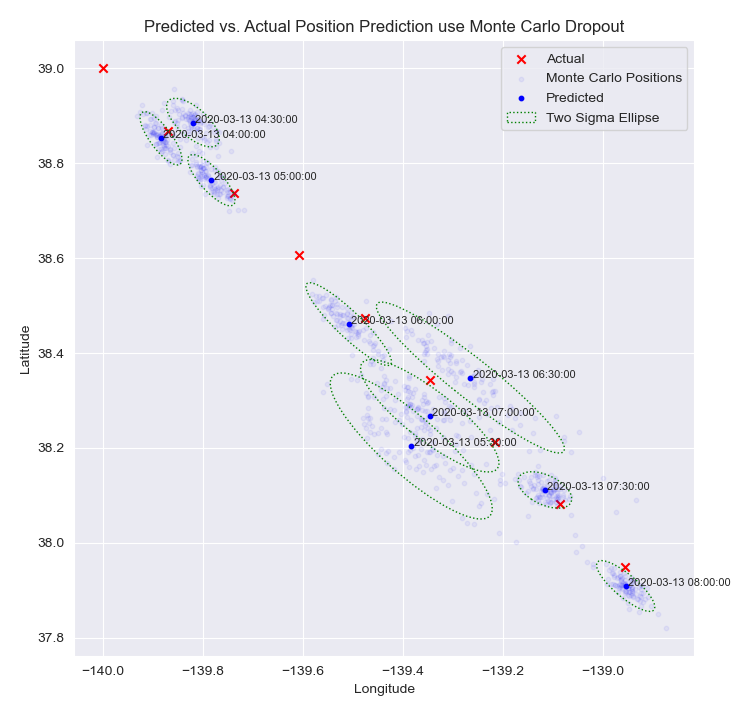

In [14]:
path = '../images_val/voyage_sims/voyages/30_clouds/' 
monte_carlo_df, preds_mc, act_pos = predict_positions(path)

print('Mean Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].mean()))
print('Standard Deviation of Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].std()))

display(monte_carlo_df)

plot_lat_long(preds_mc, act_pos, monte_carlo_df,show_track = False)

The results above show the model's performance on images that are randomly obscured with cloud cover. A cloud cover of 4/8 was selected for test. The clouds are randomly distributed in terms of shape, size, and overlap and simply obscure the proportion of the sky specified.

**The Good and the Bad, With Images**

The 04:30, 05:00, 06:00, 07:30, and 08:00 position predictions are all less than 3 nm from the actual prediction. The 05:30 prediction is 25 nm from the actual position.

Since the cloud shape, size, and location is random, we need to examine the images to see if there's any discernable pattern between the good and pred predictions. 

**04:30** (error less than 3 NM)

![](../images_val/voyage_sims/voyages/30_clouds/L38.8687LON-139.8686T2020-03-13-04-30-00.png)

**05:00** (error less than 3 NM)

![](../images_val/voyage_sims/voyages/30_clouds/L38.7373LON-139.7375T2020-03-13-05-00-00.png)

**06:00** (error less than 3 NM)

![](../images_val/voyage_sims/voyages/30_clouds/L38.4747LON-139.476T2020-03-13-06-00-00.png)

**07:30** (error less than 3 NM)

![](../images_val/voyage_sims/voyages/30_clouds/L38.0807LON-139.0855T2020-03-13-07-30-00.png)

**08:00** (error less than 3 NM)

![](../images_val/voyage_sims/voyages/30_clouds/L37.9493LON-138.9558T2020-03-13-08-00-00.png)

**05:30** (26 NM error)

![](../images_val/voyage_sims/voyages/30_clouds/L38.606LON-139.6066T2020-03-13-05-30-00.png)

Whatever is driving the difference in prediction error between images and cloud formations is not immediately apparent to the author.

Further analysis will have to conducted into which constellations, major stars or patterns therein are of the most importance to the model for position classification. 

### III. Leaving the training Grid

Predictng Each Position 100 Times
Mean Position Error: 22.63 NM
Standard Deviation of Position Error: 21.11 NM


,time,pred_lat,pred_long,actual_lat,actual_long,Error
0,2020-03-13 08:00:00,38.013344,-138.924789,38.544,-138.3996,40.345662
1,2020-03-13 07:30:00,38.590057,-139.929642,38.601,-138.5990,62.442793
2,2020-03-13 07:00:00,38.182713,-139.313080,38.658,-138.7987,37.412919
3,2020-03-13 06:30:00,38.653702,-139.613922,38.715,-138.9985,29.076371
4,2020-03-13 06:00:00,38.783722,-139.503815,38.772,-139.1985,14.307651
5,2020-03-13 05:30:00,38.928604,-139.651321,38.829,-139.3986,13.239420
6,2020-03-13 05:00:00,38.823948,-139.637360,38.886,-139.5989,4.136867
7,2020-03-13 04:30:00,38.926537,-139.804016,38.943,-139.7994,1.011726
8,2020-03-13 04:00:00,38.973854,-139.988770,39.000,-140.0000,1.654890


Number of unique waypoints:  1919


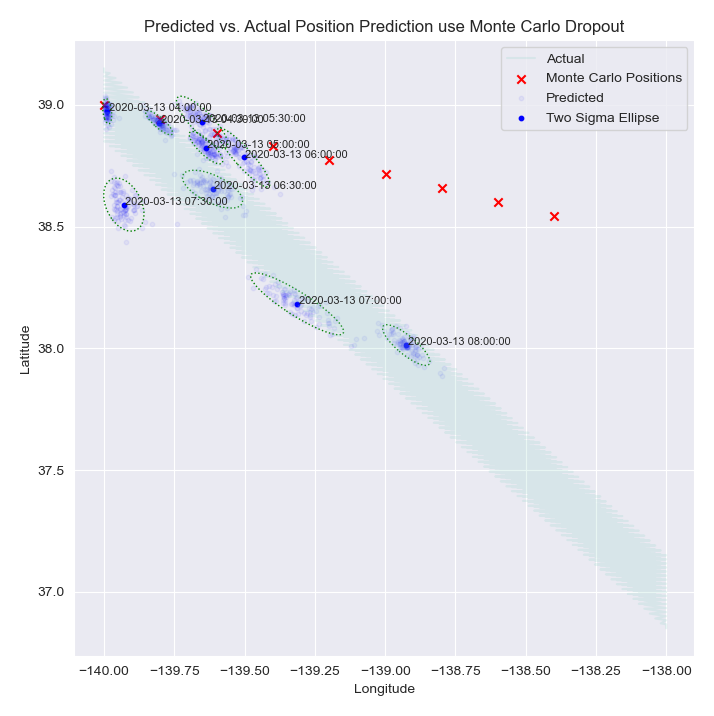

In [15]:
path = '../images_val/voyage_sims/voyages/30_easting/' 
monte_carlo_df, preds_mc, act_pos = predict_positions(path)

print('Mean Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].mean()))
print('Standard Deviation of Position Error: {:0.2f} NM'.format(monte_carlo_df['Error'].std()))

display(monte_carlo_df)

plot_lat_long(preds_mc, act_pos, monte_carlo_df,show_track = True)

We see that the model performed as expected for half an hour of travel off of the modeled route, fixing two positions within a mile of their actual position. However, due to the vessel's high speed, we quickly reached the end of the 10 nm Northern buffer zone. The 0500 fix is already more than 5 miles to the North of the Northern buffer, and we see that the confidence ellipse scrapes the actual position. However, once the vessel significantly left the training grid all accuracy was lost and the predicted positions become randomly around the grid. Note: The above plot shows the training grid as a visual aid. 

# Conclusions

What worked well:

1. The dense spatio temporal grid architecture and was successful. The neural network was able to reliably predict a position within 1 nm of its actual position provided that position was within the model's training grid parameters, i.e. the time was some multiple of 6 minutes and the position was within the 150 mile by 20 mile training grid.

2. The final model topology was successful. In particular, the Monte Carlo Dropout layers proved to be an effective way to increase the model's accuracy. An additional benefit of this method is that the position can now be interpreted as a probability distribution. The model predicts each position 100 times and plots the mean as the final predicted position, and from the predictions we are able to perform Eigendecomposition and plot a confidence ellipse to better understand the model's uncertainty.  

What did not work:

1. The model is memorizing what the sky looks like in the future, not learning a sequence of images of the sky. As a result, temporal interpolation is poor and an image taken at a time outside of the model's regular training interval results in an erroneous position.
While our study tried to implement a hybrid CNN-LSTM model to train on a sequence of the sky, the results were poor and we will leave this as an area of further exploration. Our CNN-LSTM model script is provided in the repository as a starting point for future projects.

2. Clouds clearly impact the predictive power of the model. A potential solution to this problem in an actual implementation would likely involve using near-infrared cameras to capture the images. Astronomers often use near-infrared observations to study the stars and their environments, as well as to observe objects that are obscured in visible light, such as dust clouds and protoplanetary disks.

3. Once the vessel leaves the training grid, all predictive power is lost. This is not unlike sailing without a chart of the area, if you do not have some sort of navigational armature upon which to base your predictions it is exceedingly difficult to navigate. An actual implementation would involve either having pre-loaded models for the intended transit or the ability to create and hot-swap models underway. 